In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,ConstantKernel as C
from scipy.stats import zscore
np.random.seed(1)


In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [9]:
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.,10.5, 11., 13.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 15, 1000)).T

In [10]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

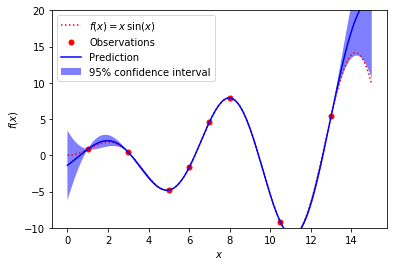

In [11]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

In [15]:
# now the noisy case
X = np.linspace(0.1, 14.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

In [16]:
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

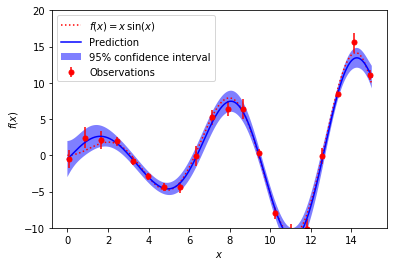

In [17]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

In [2]:
# Make sure the file is within the same directory, or you know the path to the mouse set 1 data
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle) 

In [3]:
reads = mouse_set_1['reads']
qpcr = mouse_set_1['qpcr']
otu_taxonomy = mouse_set_1['otu_taxonomy']
times = mouse_set_1['times']

In [4]:
high_fat = [21.5,28.5]
gram_pos = [35.5,42.5]
gram_neg = [50.5,57.5]

is_high_fat = np.logical_and(np.array(times)>=high_fat[0], np.array(times)<high_fat[1]) 
is_gram_pos = np.logical_and(np.array(times)>=gram_pos[0], np.array(times)<gram_pos[1]) 
is_gram_neg = np.logical_and(np.array(times)>=gram_neg[0], np.array(times)<gram_neg[1]) 

In [5]:
all_abs_amount = []
all_abs_amount_z = []
all_mice = list(reads.keys())
for mouse_id in all_mice:
    mouse_reads_df = reads[mouse_id]
    m_total_amount = qpcr[mouse_id]['mean'].values
    all_OTU = list(mouse_reads_df.index)

    m_reads_values=reads[mouse_id].values
    m_reads_values_sum=sum(m_reads_values)

    m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
    for idx, otu in enumerate(all_OTU):
        these_reads = mouse_reads_df.loc[otu]
        this_relative_abundance = these_reads.values/m_reads_values_sum
        this_abs_abundance = this_relative_abundance * m_total_amount
        m_all_abs_amount[idx,:] = this_abs_abundance

    m_all_abs_amount_z = zscore(m_all_abs_amount, axis = 1)
    all_abs_amount.append(m_all_abs_amount)
    all_abs_amount_z.append(m_all_abs_amount_z)

In [6]:
all_abs_amount[0].shape

(202, 75)

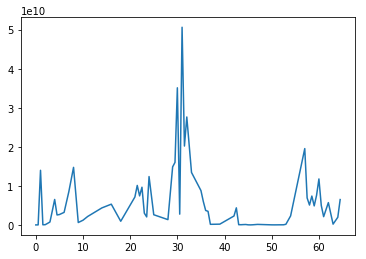

In [7]:
plt.plot(times,all_abs_amount[0][0,:])

In [187]:
nOTU = 3
X = np.array(times).reshape(-1,1)
y = all_abs_amount[1][nOTU,:].reshape(-1,1)
y = y/np.max(y)
x = np.atleast_2d(np.linspace(0, 65, 50)).T
# Instantiate a Gaussian Process model
# kernel = C(1, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
kernel = C(1, (1e-3, 1e3)) * RBF(0.01, (1e-3, 1e3)) + WhiteKernel(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)
print(gp.log_marginal_likelihood_value_)

28.266892492714064


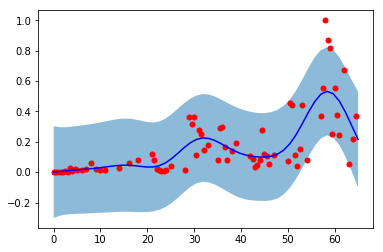

In [188]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x.flatten(), y1 = y_pred.flatten()+1.96*sigma, y2 = y_pred.flatten()-1.96*sigma, alpha = 0.5)


In [189]:
n_repeat = 100
n_samples = 10

all_samples = gp.sample_y(x,n_samples=n_samples*n_repeat).squeeze()
samples = np.zeros((x.shape[0], n_repeat))
for i in range(n_repeat):
    this_mean = np.mean(all_samples[:,np.arange(n_samples)+i*n_samples], axis = 1)
    this_mean[this_mean<0] = 0
    samples[:,i] = this_mean
all_samples.shape

(50, 1000)

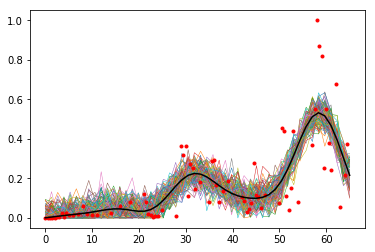

In [190]:
plt.plot(x, samples,linewidth=0.5);
plt.plot(X,y,'r.');
plt.plot(x,y_pred,'k');

In [86]:
# times
np.array(times).reshape(-1,1).shape, y.shape

((75, 1), (75, 1))

In [126]:
from scipy.interpolate import interp1d
y = all_abs_amount[0][np.array([0,1]),:].T
f = interp1d(np.array(times), y, axis = 0,kind='linear', fill_value='extrapolate')
xnew = np.arange(0,times[-1]+0.5,0.5)
ynew = f(xnew)

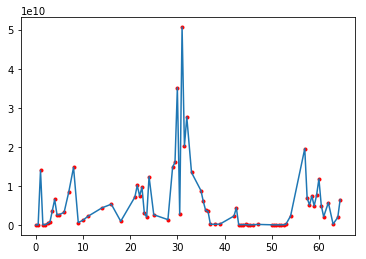

In [127]:
plt.plot(times, y[:,0],'r.')
plt.plot(xnew,ynew[:,0])

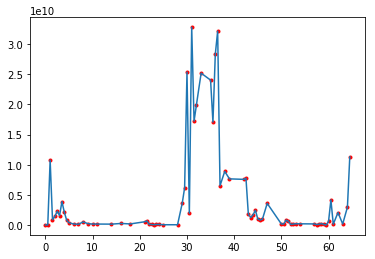

In [128]:
plt.plot(times, y[:,1],'r.')
plt.plot(xnew,ynew[:,1])

In [129]:
for i,t in enumerate(times):
    print(i,t)

0 0.0
1 0.5
2 1.0
3 1.5
4 2.0
5 2.5
6 3.0
7 3.5
8 4.0
9 4.5
10 5.0
11 6.0
12 7.0
13 8.0
14 9.0
15 10.0
16 11.0
17 14.0
18 16.0
19 18.0
20 21.0
21 21.5
22 22.0
23 22.5
24 23.0
25 23.5
26 24.0
27 25.0
28 28.0
29 29.0
30 29.5
31 30.0
32 30.5
33 31.0
34 31.5
35 32.0
36 33.0
37 35.0
38 35.5
39 36.0
40 36.5
41 37.0
42 38.0
43 39.0
44 42.0
45 42.5
46 43.0
47 43.5
48 44.0
49 44.5
50 45.0
51 45.5
52 46.0
53 47.0
54 50.0
55 50.5
56 51.0
57 51.5
58 52.0
59 52.5
60 53.0
61 54.0
62 57.0
63 57.5
64 58.0
65 58.5
66 59.0
67 59.5
68 60.0
69 60.5
70 61.0
71 62.0
72 63.0
73 64.0
74 64.5


In [132]:
is_high_fat

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])